In [1]:
import gmplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN

import math
import time
import datetime
import os

filedir = 'Z:/C Brace/GPS Analysis'

## Wear Time w/ GPS Data

In [4]:
def getDatetime(stringDTSeries):
    try:
        return [datetime.datetime.strptime(DT,'%m/%d/%Y %I:%M %p') for DT in stringDTSeries]
    except(ValueError):
        return [datetime.datetime.strptime(DT,'%m/%d/%Y %H:%M') for DT in stringDTSeries]

### Match wear time to GPS data

In [6]:
for device in ['CBrace', 'SCO', 'KAFO']:

    print(device)
    if device == 'KAFO':
        device2 = 'Baseline'
    else:
        device2 = device
    
    for i in range(8,32):

        if not(os.path.isfile(filedir + '\GPSWT\CBR' + str(i).zfill(2) + '_' + device2 + '.csv')):

            try:
                try:
                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/Merged/WearTime_' + device + '_Device.csv')

                    try:
                        I = data.index
                        I = [i[0] for i in I]
                        
                    except(IndexError):
                        I = [i for i in data.iloc[:,0]]
                        I.pop(0)

                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/Merged/WearTime_' + device + '_Device.csv',
                                       skiprows=I.index('Date/Time Start')+2)
                except(OSError):
                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/WearTime_' + device + '_Device.csv')

                    try:
                        I = data.index
                        I = [i[0] for i in I]
                        
                    except(IndexError):
                        I = [i for i in data.iloc[:,0]]
                        I.pop(0)

                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/WearTime_' + device + '_Device.csv',
                                       skiprows=I.index('Date/Time Start')+2)

                DF=data[['Date/Time Start', 'Date/Time Stop']]

                WT_StartStop = DF.apply(getDatetime)
                WT_StartStop = pd.concat([WT_StartStop, data['Wear or Non-Wear']], axis=1)
                WT_StartStop = WT_StartStop[WT_StartStop['Wear or Non-Wear']=='Wear']

                GPSdata = pd.read_csv(filedir +  '/GPS Data/CBR' + str(i).zfill(2) + '_' + device2  + '.csv')

                GPS_TS = GPSdata['LOCAL DATE'] + ' ' + GPSdata['LOCAL TIME']

                try:
                    GPS_TS = [datetime.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S') for DT in GPS_TS]
                except(ValueError):
                    GPS_TS = [datetime.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S') for DT in GPS_TS]

                WT_StartStop.iloc[0,0]

                GPS_TS = pd.Series(GPS_TS)

                inds = (GPS_TS<WT_StartStop.iloc[0,1]) & (GPS_TS>WT_StartStop.iloc[0,0])

                GPS_WT = ['Non-Wear'] * len(inds)
                GPS_WT = pd.Series(GPS_WT)

                def getWT(StartStop):
                    inds = (GPS_TS<StartStop['Date/Time Stop']) & (GPS_TS>StartStop['Date/Time Stop'])
                    GPS_WT[inds] = 'Wear'
                    return GPS_WT

                for Start, Stop in zip(WT_StartStop['Date/Time Start'], WT_StartStop['Date/Time Stop']):
                    inds = (GPS_TS<Stop) & (GPS_TS>Start)
                    GPS_WT[inds] = 'Wear'

                GPS = pd.concat([GPSdata, GPS_WT],axis=1).rename(index=int,columns={0:'Wear/Non-Wear'})

                GPS.to_csv(filedir + '\GPSWT\CBR' + str(i).zfill(2) + '_' + device2 + '.csv')
            except(OSError):
                print('CBR' + str(i).zfill(2))

CBrace
CBR09
CBR10
CBR12
CBR14
CBR17
CBR18
CBR20
CBR23
CBR29
SCO
CBR09
CBR10
CBR12
CBR13
CBR14
CBR17
CBR18
CBR20
CBR23
CBR25
CBR29
KAFO
CBR08
CBR09
CBR10
CBR12
CBR13
CBR14
CBR17
CBR18
CBR20
CBR23
CBR29


In [672]:
D = {'CBrace':float('nan'), 'SCO':float('nan'), 'Baseline':float('nan')}

for device in ['CBrace', 'SCO', 'Baseline']:

    print(device)
    
    Time = [float('nan')] * 31; Freq = [float('nan')]*31; WTRatio = [float('nan')]*31;
    
    for i in range(8,32):

        print('CBR' + str(i).zfill(2))
        
        try:
            Data = pd.read_csv(filedir + '/GPSWT/CBR' + str(i).zfill(2) + '_' + device + '.csv')

            Lat = Data.LATITUDE
            Lon = Data.LONGITUDE

            Data.loc[Data.iloc[:,12]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,12]=="W","LONGITUDE"]*-1
            dArray = Data[["LATITUDE","LONGITUDE"]].values

            dbscan = DBSCAN(metric='haversine', eps=100/6371000, min_samples=int(720*len(dArray)/100000), algorithm='ball_tree')
            t0 = time.clock()
            clusters = dbscan.fit(np.radians(dArray))
            t1 = time.clock()
            print(t1-t0)
            l=clusters.labels_
            print(len(np.unique(l)))
            
            f = sum(np.diff(l)!=0)/(len(l)-1)*6*60*24
            t = [sum(l==c) for c in np.unique(l)]
            wt = [sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c) for c in np.unique(l)]
            
            Freq[i-1] = f; Time[i-1] = t; WTRatio[i-1] = wt
            
        except(OSError):
            print('No File')
            
    DF = pd.DataFrame({'Time':Time, 'WTRatio':WTRatio, 'Freq':Freq})
    D[device] = DF
    
Results = pd.Panel(D)

CBrace
CBR08
100.55816235602833
2
CBR09
No File
CBR10
No File
CBR11
288.3915131750982
4
CBR12
No File
CBR13
31.07151658483781
9
CBR14
No File
CBR15
44.30034200218506
15
CBR16
65.30661613214761
3
CBR17
No File
CBR18
No File
CBR19
485.62958200788125
3
CBR20
No File
CBR21
434.6055343602784
5
CBR22
5.0306613279972225
20
CBR23
No File
CBR24
734.5858826232143
2
CBR25
1266.1001403247938
4
CBR26
2499.2626863892656
3
CBR27
149.99613608024083
2
CBR28
750.3699912019074
2
CBR29
No File
CBR30
375.2338046366349
6
CBR31
370.8499876551796
4
SCO
CBR08
80.66389086726122
7
CBR09
No File
CBR10
No File
CBR11
5.317440410377458
6
CBR12
No File
CBR13
No File
CBR14
No File
CBR15
117.10836252267472
7
CBR16
145.47288984037004
4
CBR17
No File
CBR18
No File
CBR19
554.2438560170121
2
CBR20
No File
CBR21
387.88039182592183
5
CBR22
0.7741418723016977
12
CBR23
No File
CBR24
120.52053325693123
2
CBR25
No File
CBR26
584.151571540162
4
CBR27
1380.041889873799
2
CBR28
722.0144395933021
2
CBR29
No File
CBR30
95.25210529891

In [673]:
def getNClusters(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(len(e))
    
    return X

In [674]:
N_Clusters = Results.minor_xs('Time').apply(getNClusters) # number of clusters for each subject/brace

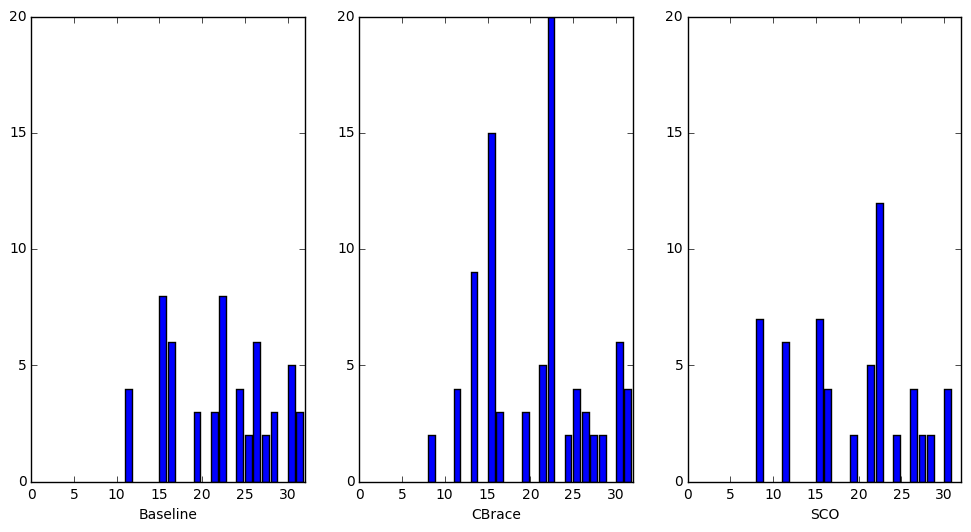

In [675]:
fig = plt.figure(figsize=(12,6))
for i, C in enumerate(N_Clusters.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(N_Clusters[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,20)
    ax.set_xlabel(C)

In [676]:
def getTimeAverage(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(np.mean(np.sort(e)[0:len(e)-1])/np.max(e)) # Average time spent in other clusters relative to Home

    return X

def getTimeRatio(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(np.sum(np.sort(e)[0:len(e)-1])/np.max(e)) # Total time spent in other clusters relative to Home

    return X

In [677]:
MeanTime = Results.minor_xs('Time').apply(getTimeAverage) # Average time spent in other clusters relative to Home
RatioTime = Results.minor_xs('Time').apply(getTimeRatio) # Total time spent in other clusters relative to Home

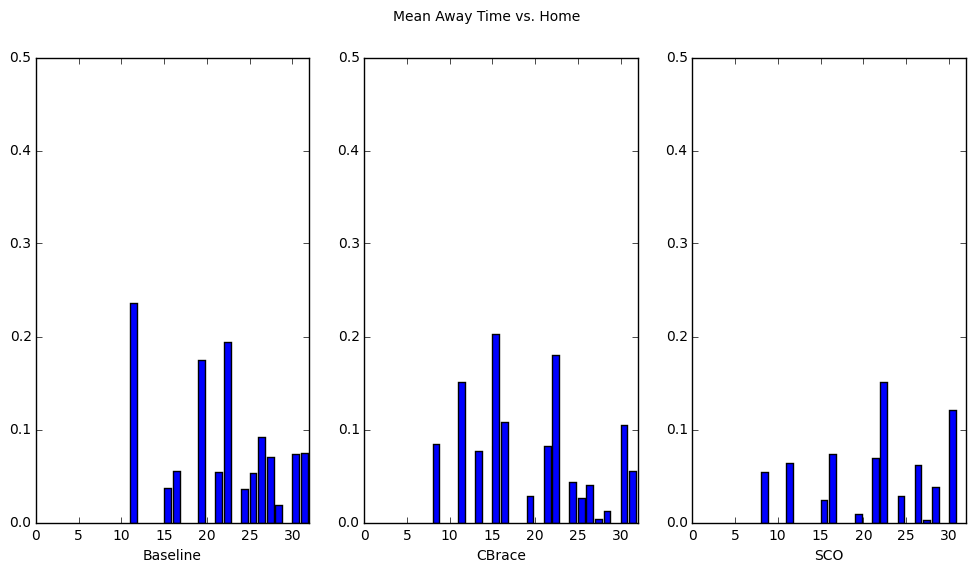

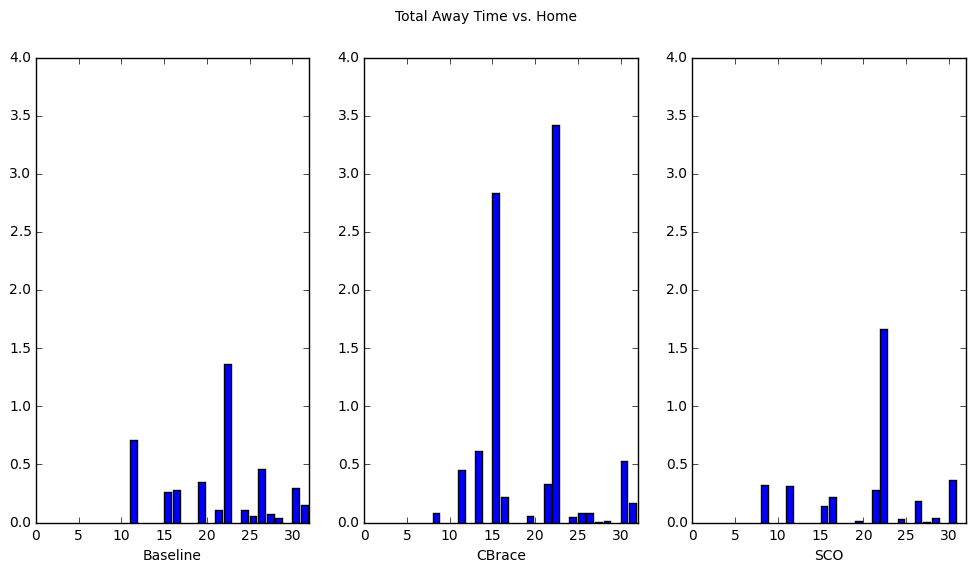

In [678]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Mean Away Time vs. Home')
for i, C in enumerate(MeanTime.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(MeanTime[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,.5)
    ax.set_xlabel(C)
    
fig = plt.figure(figsize=(12,6))
fig.suptitle('Total Away Time vs. Home')
for i, C in enumerate(RatioTime.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(RatioTime[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,4)
    ax.set_xlabel(C)

In [679]:
def getWTimeAverage(S):
    
    try:
        check = any(np.isnan(S['Time']))
    except(TypeError):
        check = np.isnan(S['Time'])
    
    if check:
        return float('nan')
    else:
        ind = np.argmax(S['Time'])
        d = pd.Series(S['WTRatio'])
        
        return d

def getWTimeHome(S):
    
    try:
        check = any(np.isnan(S['Time']))
    except(TypeError):
        check = np.isnan(S['Time'])
    
    if check:
        return float('nan')
    else:
        return S['WTRatio'][np.argmax(S['Time'])]


In [680]:
DHome = {};
DMean = {};

for C in Results.items:

    DHome[C] = Results[C].apply(getWTimeHome,axis=1)
    DMean[C] = Results[C].apply(getWTimeAverage,axis=1).apply(np.mean)
    
WTHome = pd.DataFrame(DHome) # WT ratio in Home cluster
WTMean = pd.DataFrame(DMean) # Average WT ratio in away clusters

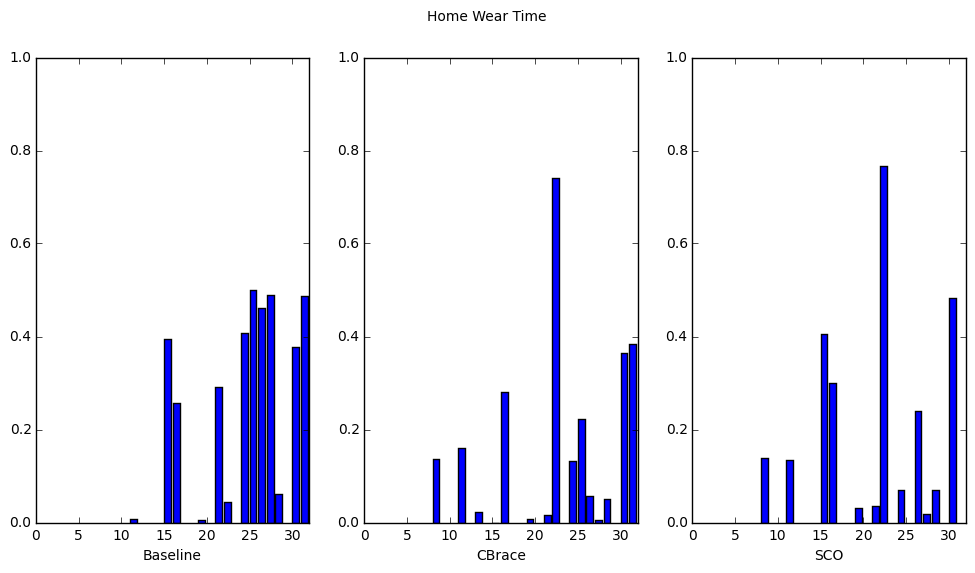

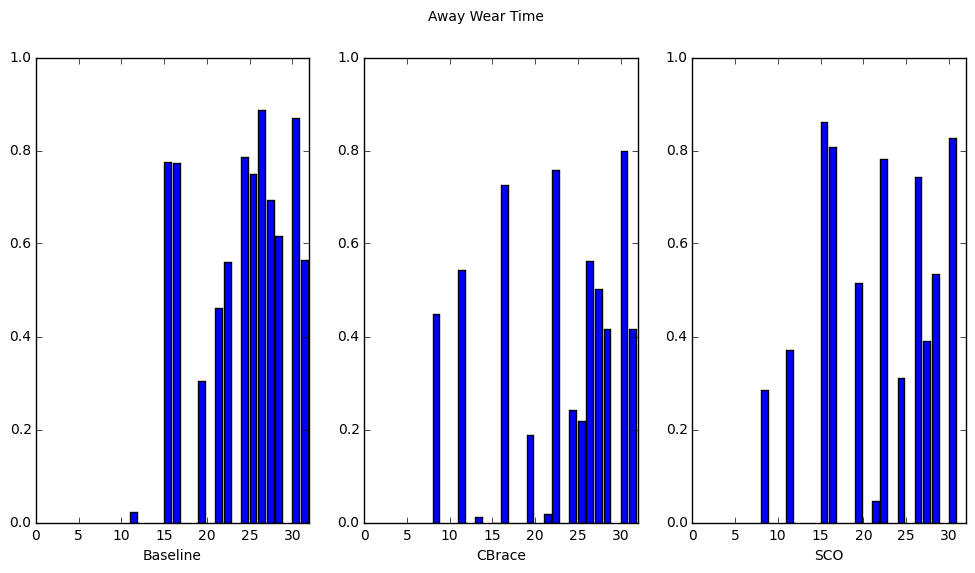

In [681]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Home Wear Time')
for i, C in enumerate(WTHome.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(WTHome[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,1)
    ax.set_xlabel(C)
    
fig = plt.figure(figsize=(12,6))
fig.suptitle('Away Wear Time')
for i, C in enumerate(WTMean.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(WTMean[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,1)
    ax.set_xlabel(C)

In [764]:
WTMean['SCO']-WTMean['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    0.348087
11         NaN
12         NaN
13         NaN
14    0.086319
15    0.033655
16         NaN
17         NaN
18    0.210914
19         NaN
20   -0.415144
21    0.220365
22         NaN
23   -0.474622
24         NaN
25   -0.144298
26   -0.302588
27   -0.080922
28         NaN
29   -0.043805
30         NaN
dtype: float64

In [765]:
WTHome['SCO']-WTHome['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    0.126550
11         NaN
12         NaN
13         NaN
14    0.011352
15    0.044296
16         NaN
17         NaN
18    0.026098
19         NaN
20   -0.255333
21    0.723778
22         NaN
23   -0.337964
24         NaN
25   -0.220680
26   -0.470001
27    0.007324
28         NaN
29    0.105429
30         NaN
dtype: float64

In [766]:
RatioTime['SCO']-RatioTime['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10   -0.391055
11         NaN
12         NaN
13         NaN
14   -0.119056
15   -0.057033
16         NaN
17         NaN
18   -0.340787
19         NaN
20    0.169901
21    0.303327
22         NaN
23   -0.080471
24         NaN
25   -0.273000
26   -0.067560
27   -0.000225
28         NaN
29    0.066856
30         NaN
dtype: float64

In [767]:
MeanTime['SCO']-MeanTime['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10   -0.172722
11         NaN
12         NaN
13         NaN
14   -0.013593
15    0.017994
16         NaN
17         NaN
18   -0.166035
19         NaN
20    0.015059
21   -0.043135
22         NaN
23   -0.007549
24         NaN
25   -0.030015
26   -0.067560
27    0.019125
28         NaN
29    0.047005
30         NaN
dtype: float64

In [768]:
N_Clusters['SCO']-N_Clusters['Baseline']

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10     2
11   NaN
12   NaN
13   NaN
14    -1
15    -2
16   NaN
17   NaN
18    -1
19   NaN
20     2
21     4
22   NaN
23    -2
24   NaN
25    -2
26     0
27    -1
28   NaN
29    -1
30   NaN
dtype: float64

## Testing Code

In [2]:
Data = pd.read_csv(filedir + '/GPS Data/CBR01_CBrace.csv')

In [3]:
Data

,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z
0,1,1,FIXED,5/29/2014,15:36:05,5/29/2014,10:36:05,0,41.894939,N,87.617634,W,156.143814,0.440751,83.233567,0,0,0
1,2,1,FIXED,5/29/2014,15:36:15,5/29/2014,10:36:15,0,41.894988,N,87.617085,W,183.315170,0.787720,138.834256,0,0,0
2,3,1,FIXED,5/29/2014,15:36:25,5/29/2014,10:36:25,0,41.894911,N,87.616995,W,179.808655,1.359044,149.022693,0,0,0
3,4,1,FIXED,5/29/2014,15:36:35,5/29/2014,10:36:35,0,41.894365,N,87.616554,W,185.597916,2.979795,216.134223,0,0,0
4,5,1,FIXED,5/29/2014,15:36:45,5/29/2014,10:36:45,0,41.894331,N,87.616587,W,188.740662,0.678069,331.371565,0,0,0
5,6,1,FIXED,5/29/2014,15:36:55,5/29/2014,10:36:55,0,41.894380,N,87.616623,W,190.383270,1.267886,302.784304,0,0,0
6,7,1,FIXED,5/29/2014,15:37:05,5/29/2014,10:37:05,0,41.894432,N,87.616732,W,192.742874,0.815659,154.856028,0,0,0
7,8,1,FIXED,5/29/2014,15:37:15,5/29/2014,10:37:15,0,41.894429,N,87.616730,W,192.711517,0.506951,348.885099,0,0,0
8,9,1,FIXED,5/29/2014,15:37:25,5/29/2014,10:37:25,0,41.894459,N,87.616738,W,193.771820,1.410147,346.351365,0,0,0
9,10,1,FIXED,5/29/2014,15:37:35,5/29/2014,10:37:35,0,41.894525,N,87.616759,W,194.747147,1.059377,341.458812,0,0,0


In [67]:
Lat = Data.LATITUDE
Lon = Data.LONGITUDE

In [68]:
Data.loc[Data.iloc[:,11]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,11]=="W","LONGITUDE"]*-1

In [69]:
gmap = gmplot.GoogleMapPlotter(41.894939,-87.617634,12)

In [70]:
gmap.heatmap(Lat,Lon, threshold=1, radius=100)
gmap.scatter(Lat[1:5000],Lon[1:5000],'k', size=40, marker=False)

In [71]:
gmap.draw("testCBR.html")

## Clustering

In [796]:
Data = pd.read_csv('./GPSWT/CBR22_SCO.csv')

Lat = Data.LATITUDE
Lon = Data.LONGITUDE

Data.loc[Data['E/W']=="W","LONGITUDE"] = Data.loc[Data['E/W']=="W","LONGITUDE"]*-1

dArray = Data[["LATITUDE","LONGITUDE"]].values

In [797]:
dbscan = DBSCAN(metric='haversine', eps=100/6371000, min_samples=int(720*len(dArray)/100000), algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(dArray))
t1 = time.clock()
print(t1-t0)

0.8026395991910249


In [798]:
l=clusters.labels_
print(len(l))
np.unique(l)

4924


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [799]:
colors=np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmyk'])

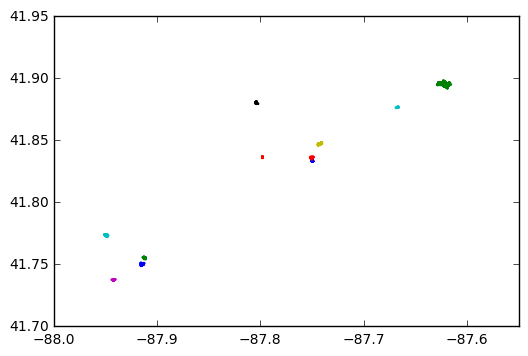

In [800]:
plt.scatter(dArray[l!=-1][:,1],dArray[l!=-1][:,0],color=colors[l[l!=-1]], s=1)

In [801]:
gmap = gmplot.GoogleMapPlotter(41.84,-87.75,12)
for c in np.unique(l[l!=-1]):
    m = [np.mean(dArray[l==c][:,0]), np.mean(dArray[l==c][:,1])]
    # Size based on physical space covered by cluster
    s1 = (np.max(dArray[l==c][:,0])-np.min(dArray[l==c][:,0]))*400000
    s2 = (np.max(dArray[l==c][:,1])-np.min(dArray[l==c][:,1]))*400000
    print(s1*s2)
    
#     # Size based on time spent in cluster
#     s1 = sum(l==c)
#     s2=1000
#     print(math.sqrt(s1*s2))
    
    # colorscale based on weartime fraction
    col = sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c)
    
    gmap.scatter([m[0], m[0]],[m[1], m[1]],color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=math.sqrt(s1*s2), marker=False)
# Save as html
gmap.draw("SCO22.html")

211019.52
12161260.8
924154.879995
1153932.96
345846.240001
1376333.44
695339.519997
1108645.12
723287.040006
15380.3200015
336130.079999
